# Probabilistic Programming 3: Hidden Markov modeling
## Variational inference

In this notebook, we are looking at inference in a dynamical system.

### Preliminaries

- Goal 
  - Learn to apply ForneyLab to a dynamical system.
- Materials        
  - Mandatory
    - These lecture notes.
  - Optional
    - [Cheatsheets: how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).
    - [Probabilistic Programming notebook](https://github.com/bertdv/BMLIP/tree/master/lessons/notebooks/probprog/Probabilistic-Programming.ipynb)
    - [Getting started with ForneyLab](https://biaslab.github.io/forneylab/docs/getting-started/).

In [1]:
using Pkg
Pkg.activate("workspace")
Pkg.instantiate();

using Logging; disable_logging(LogLevel(0))
using ForneyLab
using Plots
pyplot()
include("../scripts/pp-3.jl");

Activating environment at `~/Dropbox/Courses/tueindhoven/5SSD0 - Bayesian Machine Learning & Information Processing/BMLIP/lessons/notebooks/probprog/workspace/Project.toml`


### Data generation

In this problem setting, data is generated in the form of states over time. For example, proteins that fold into one of several functional configurations or machine translation, where one observes writing in one language and aims to infer writing in another language (both being finite sets of symbols). We don't have perfect measurement tools and have to assume measurement noise. 

We will generate a synthetic data set as follows: we pick an initial state and evolve the state using a fixed state transition matrix. Then we observe the state using a fixed observation probability, referred to as an _emission_ matrix. 

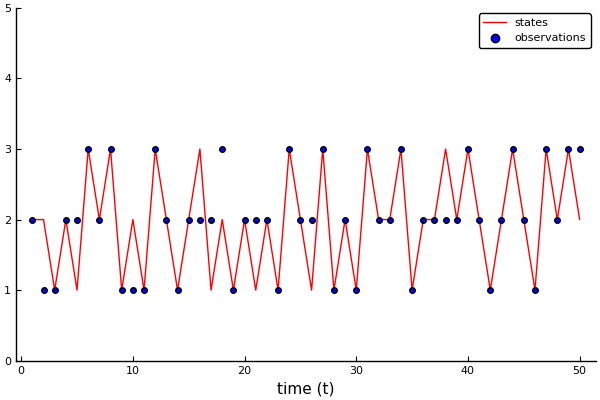

In [2]:
# There are 3 possible states and each variable is in one of those (one-hot encoding)
K = 3

# Length of time-series
T = 50

# Transition matrix of latent variables
transition = [0.3  0.5  0.2;
              0.6  0.2  0.7;
              0.1  0.3  0.1]

# Emission matrix for observed variables
emission = [0.9  0.1  0.0;
            0.1  0.8  0.2;
            0.0  0.1  0.8]

# Preallocate data arrays
states = Array{Int64,1}(undef, T)
observations = Array{Int64,1}(undef, T)

# Initial state
state_0 = 1

# Keep previous state in memory
state_tmin = state_0

# Generate data for entire time-series
for t = 1:T
    
    # Transition from previous state
    states[t] = sample(ProbabilityDistribution(Categorical, p=transition[:, state_tmin])).nzind[1]
    
    # Emission of current state
    observations[t] = sample(ProbabilityDistribution(Categorical, p=emission[:, states[t]])).nzind[1]
    
    # Update previous state
    state_tmin = states[t]
    
end

# Visualization.
plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false)
scatter!(1:T, observations, color="blue", label="observations")
xlabel!("time (t)")

## Model Specification

The Hidden Markov model is a state-space model of the form:

$$\begin{align}
x_t \sim&\ \text{Cat}(A x_{t-1}) \\
y_t \sim&\ \text{Cat}(B x_t)
\end{align}$$

where $A$ is the state transition matrix and $B$ is the emission matrix. The states $x$ are indexed by time $t$, ranging from $0$ to $T$. The observations $y$ are indexed from $1$ to $T$. 

### Model 1: estimate states

We will first assume we know the transition and emission matrices. Based on these, we purely want to estimate states from observations. ForneyLab has a special "Transition" node that applies a linear transformation to a variable. For this to work, the states and observations have to be in a "one-hot encoding" form: $x_i = 3 \iff x_i = [0. 0. 1.]$ for $K=3$.

In [3]:
# Map states and observations to one-hot encodings
states_1h = one_hot.(states, K)
observations_1h = one_hot.(observations, K)

50-element Array{Array{Float64,1},1}:
 [0.0, 1.0, 0.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [0.0, 1.0, 0.0]
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [1.0, 0.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 0.0]
 ⋮              
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 0.0]
 [1.0, 0.0, 0.0]
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 0.0]
 [1.0, 0.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 0.0]
 [0.0, 0.0, 1.0]
 [0.0, 0.0, 1.0]

We start by initializing the graph and defining the initial state to be Categorically distributed. We then define two vectors of variables, with $x$ being the linear transition based on a previous state and $y$ being the linear transition from a state to an observation. We feed in the two matrices for now, but later we will put priors on their coefficients and estimate them simultaneously.

In [4]:
# # Initialize a graph
# graph1 = FactorGraph()

# # Preallocate variable arrays (one-hot encodings)
# x = Vector{Variable}(undef, T)
# y = Vector{Variable}(undef, T)

# # Prior for initial state
# @RV x_0 ~ Categorical(ones(K)/K)

# # Keep previous state in memory
# x_tmin = x_0

# # Iterate over time
# for t = 1:T
    
#     # State transition
#     @RV x[t] ~ Transition(x_tmin, transition)
    
#     # Observation emission
#     @RV y[t] ~ Transition(x[t], emission)
    
#     # Update previous state
#     x_tmin = x[t]
    
#     placeholder(y[t], :y, index=t, dims=(3,))
# end;

Now, we generate the inference algorithm and execute it.

In [5]:
# Meta.parse(algo)

# messages = Vector{Message}(undef, 4)

# messages[1] = ruleVBCategoricalOut(nothing, ProbabilityDistribution(Multivariate, PointMass, m=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]))
# #= none:6 =#
# messages[2] = ruleSVBTransitionOutVCD(nothing, messages[1], ProbabilityDistribution(MatrixVariate, PointMass, m=[0.3 0.5 0.2; 0.6 0.2 0.7; 0.1 0.3 0.1]))
# #= none:7 =#
# messages[3] = ruleVBTransitionIn1(ProbabilityDistribution(Multivariate, PointMass, m=(data[:y])[1]), nothing, ProbabilityDistribution(MatrixVariate, PointMass, m=[0.9 0.1 0.0; 0.1 0.8 0.2; 0.0 0.1 0.8]))
# #= none:8 =#
# messages[4] = ruleSPEqualityCategorical(messages[2], messages[3], nothing)
# #= none:9 =#

In [6]:
# # Define the recognition factorization
# q = RecognitionFactorization([x_0; x], ids=[:X])

# # Generate VMP algorithm
# algo = variationalAlgorithm(q)

# # Construct variational free energy evaluation code
# algo_F = freeEnergyAlgorithm(q);

# # Load algorithms
# eval(Meta.parse(algo))
# eval(Meta.parse(algo_F))

# # Initialize recognition distribution marginals
# marginals = Dict{Symbol, ProbabilityDistribution}()
# for t = 0:T
#     marginals[:x_*t] = vague(ForneyLab.Categorical, 3)
# end

# # Initialize data
# data = Dict(:y => observations_1h)

# # Number of iterations to optimize the approximation
# num_iterations = 10

# # Preallocate Free Energy array
# F = Vector{Float64}(undef, num_iterations)

# # Run algorithm
# for i = 1:num_iterations
    
#     # Update states
#     stepX!(data, marginals)

#     # Track Free Energy
#     F[i] = freeEnergy(data, marginals)
# end;

Let's first have a look to see whether the variational inference procedure has converged

In [7]:
# # Plot free energy
# plot(1:num_iterations, F, color="black", label="", xlabel="iterations", ylabel="Free Energy")
# xlims!(0, num_iterations)

Alright. Looking good. Now to visualize the state estimates.

In [8]:
# # Extract state estimates
# states_estimated = argmax.([mean(marginals[:x_*t]) for t = 1:T])

# # Visualization
# plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false, xlabel="time (t)")
# plot!(1:T, states_estimated, color="green", label="inferred")
# scatter!(1:T, observations, color="blue", label="observations")

### Model 2: transition matrix estimation

At the moment, we assume we know how the states evolve over time. This is not an unreasonable assumption; in protein folding we know exactly _how_ the protein changes state, i.e. through the signaling of another molecule, and we know the concentration of signal molecules. However, in other applications we do not necessarily know the transition matrix. 

We can estimate the transition matrix by letting the coefficients be latent variables and posing a prior.

In [9]:
# # Initialize a graph
# graph2 = FactorGraph()

# # Preallocate variable arrays (one-hot encodings)
# x = Vector{Variable}(undef, T)
# y = Vector{Variable}(undef, T)

# # Prior for initial state
# @RV x_0 ~ Categorical(ones(K)/K)

# # Prior for transition matrix
# @RV A ~ Dirichlet(ones(K, K))

# # Keep previous state in memory
# x_tmin = x_0

# # Iterate over time
# for t = 1:T
    
#     # State transition
#     @RV x[t] ~ Transition(x_tmin, A)
    
#     # Observation emission
#     @RV y[t] ~ Transition(x[t], emission)
    
#     # Update previous state
#     x_tmin = x[t]
    
#     placeholder(y[t], :y, index=t, dims=(3,))
# end;

Again, define the inference algorithm and run it.

In [10]:
# # Define the recognition factorization
# q = RecognitionFactorization(A, [x_0; x], ids=[:A, :X])

# # Generate VMP algorithm
# algo = variationalAlgorithm(q)

# # Construct variational free energy evaluation code
# algo_F = freeEnergyAlgorithm(q);

# # Load algorithms
# eval(Meta.parse(algo))
# eval(Meta.parse(algo_F))

# # Initialize recognition distribution marginals
# marginals = Dict{Symbol, ProbabilityDistribution}()
# marginals[:A] = vague(Dirichlet, (3,3))
# for t = 0:T
#     marginals[:x_*t] = vague(ForneyLab.Categorical, 3)
# end

# # Initialize data
# data = Dict(:y => observations_1h)

# # Number of iterations to optimize the approximation
# num_iterations = 10

# # Preallocate Free Energy array
# F = Vector{Float64}(undef, num_iterations)

# # Run algorithm
# for i = 1:num_iterations
    
#     # Update states
#     stepX!(data, marginals)
#     stepA!(data, marginals)

#     # Track Free Energy
#     F[i] = freeEnergy(data, marginals)
# end;

Check for convergence.

In [11]:
# # Plot free energy
# plot(1:num_iterations, F, color="black", label="", xlabel="iterations", ylabel="Free Energy")
# xlims!(0, num_iterations)

In [12]:
# # Extract state estimates
# states_estimated = argmax.([mean(marginals[:x_*t]) for t = 1:T])

# # Visualization
# plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false, xlabel="time (t)")
# plot!(1:T, states_estimated, color="green", label="inferred")
# scatter!(1:T, observations, color="blue", label="observations")

### Model 3: states, transition and emission

We can extend the model further to also estimate the emission matrix. We'll use an informative prior for the emission matrix, because we do think that sensor noise is relatively low.

In [13]:
# Initialize a graph
graph3 = FactorGraph()

# Preallocate variable arrays (one-hot encodings)
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)

# Prior for initial state
@RV x_0 ~ Categorical(ones(K)/K)

# Prior for transition matrix
@RV A ~ Dirichlet(ones(K, K))

# Prior for emission matrix
@RV B ~ Dirichlet([10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0])

# Keep previous state in memory
x_tmin = x_0

# Iterate over time
for t = 1:T
    
    # State transition
    @RV x[t] ~ Transition(x_tmin, A)
    
    # Observation emission
    @RV y[t] ~ Transition(x[t], B)
    
    # Update previous state
    x_tmin = x[t]
    
    placeholder(y[t], :y, index=t, dims=(3,))
end;

In [14]:
# Define the recognition factorization
q = RecognitionFactorization(A, B, [x_0; x], ids=[:A, :B, :X])

# Generate VMP algorithm
algo = variationalAlgorithm(q)

# Construct variational free energy evaluation code
algo_F = freeEnergyAlgorithm(q);

# Load algorithms
eval(Meta.parse(algo))
eval(Meta.parse(algo_F))

# Initialize recognition distribution marginals
marginals = Dict{Symbol, ProbabilityDistribution}()
marginals[:A] = vague(Dirichlet, (3,3))
marginals[:B] = vague(Dirichlet, (3,3))
for t = 0:T
    marginals[:x_*t] = vague(ForneyLab.Categorical, 3)
end

# Initialize data
data = Dict(:y => observations_1h)

# Number of iterations to optimize the approximation
num_iterations = 10

# Preallocate Free Energy array
F = Vector{Float64}(undef, num_iterations)

# Run algorithm
for i = 1:num_iterations
    
    # Update states
    stepX!(data, marginals)
    stepA!(data, marginals)
    stepB!(data, marginals)

    # Track Free Energy
    F[i] = freeEnergy(data, marginals)
end;

┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = averageEnergy(::Type{Dirichlet}, ::ProbabilityDistribution{MatrixVariate,Dirichlet}, ::ProbabilityDistribution{MatrixVariate,PointMass}) at dirichlet.jl:143
└ @ ForneyLab /home/wmkouw/.julia/packages/ForneyLab/Hz4kD/src/factor_nodes/dirichlet.jl:143
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = _broadcast_getindex_evalf at broadcast.jl:630 [inlined]
└ @ Core ./broadcast.jl:630
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = differentialEntropy(::ProbabilityDistribution{MatrixVariate,Dirichlet}) at dirichlet.jl:117
└ @ ForneyLab /home/wmkouw/.julia/packages/ForneyLab/Hz4kD/src/factor_nodes/dirichlet.jl:117


Check for convergence.

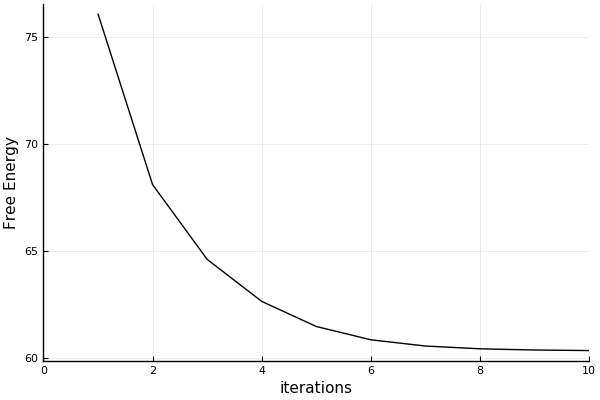

In [15]:
# Plot free energy
plot(1:num_iterations, F, color="black", label="", xlabel="iterations", ylabel="Free Energy")
xlims!(0, num_iterations)

Visualize state estimates.

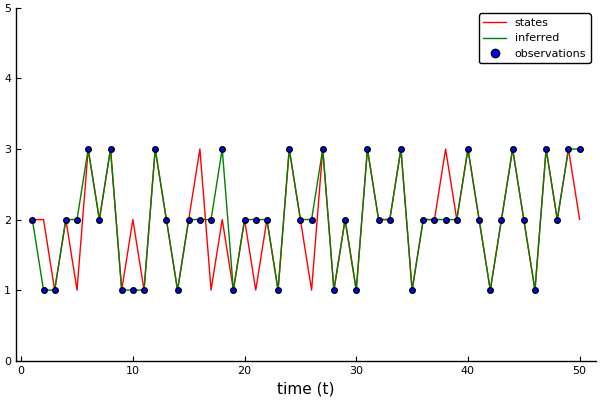

In [16]:
# Extract state estimates
states_estimated = argmax.([mean(marginals[:x_*t]) for t = 1:T])

# Visualization
plot(1:T, states, color="red", label="states", ylim=(0, 5), grid=false, xlabel="time (t)")
plot!(1:T, states_estimated, color="green", label="inferred")
scatter!(1:T, observations, color="blue", label="observations")

Visualize transition matrix estimation.

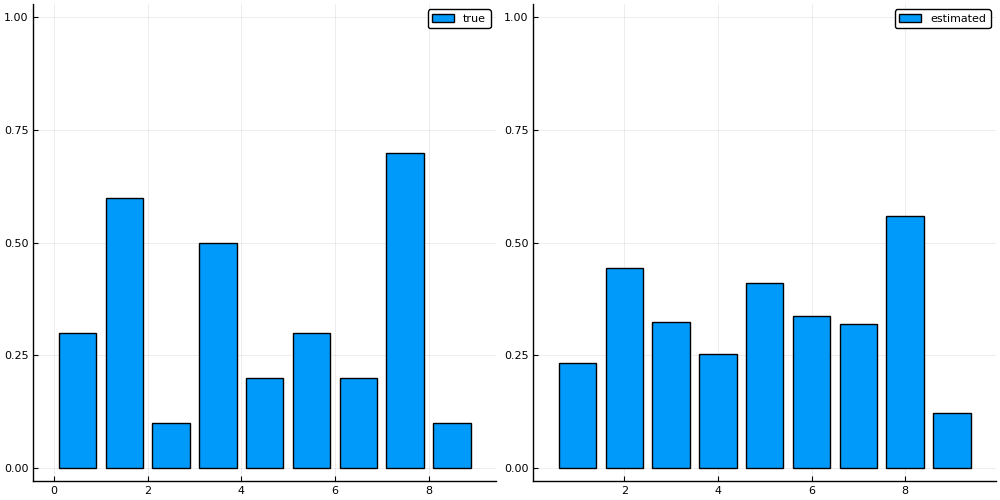

In [56]:
# Extract state estimates
transition_estimated = mean(marginals[:A])

# Visualization
l = @layout [a b]
h1 = bar(0:9, reshape(transition, (9,)), label="true", ylims=[0., 1.])
h2 = bar(reshape(transition_estimated, (9,)), label="estimated", ylims=[0., 1.])
plot(h1, h2, layout=l, size=(1000,500))